In [1]:
import os
import copy
import pickle
import sympy
import functools
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from error_injection import MissingValueError, SamplingError, Injector
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mutual_info_score, auc, roc_curve, roc_auc_score, f1_score
from scipy.optimize import minimize as scipy_min
from scipy.spatial import ConvexHull
from scipy.optimize import minimize, Bounds, linprog
from sympy import Symbol as sb
from sympy import lambdify
from tqdm.notebook import trange,tqdm
from IPython.display import display,clear_output
from random import choice

class style():
    RED = '\033[31m'
    GREEN = '\033[32m'
    BLUE = '\033[34m'
    RESET = '\033[0m'

np.random.seed(1)

In [2]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from ucimlrepo import fetch_ucirepo 
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    

def load_mpg():
    # fetch dataset
    auto_mpg = fetch_ucirepo(id=9) 

    X = auto_mpg.data.features 
    y = auto_mpg.data.targets 
    
    # with this random seed, no null value is included in the test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = copy.deepcopy(X_train).reset_index(drop=True)
    X_test = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return X_train, X_test, y_train, y_test


# first impute the data and make it hypothetically clean
def load_mpg_cleaned():
    # fetch dataset
    auto_mpg = fetch_ucirepo(id=9) 

    X = auto_mpg.data.features
    y = auto_mpg.data.targets
    
    # assumed gt imputation
    imputer = KNNImputer(n_neighbors=10)
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = copy.deepcopy(X_train).reset_index(drop=True)
    X_test = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = load_mpg_cleaned()

In [5]:
X_train

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,350.0,8.0,125.0,3900.0,17.4,79.0,1.0
1,455.0,8.0,225.0,3086.0,10.0,70.0,1.0
2,91.0,4.0,68.0,2025.0,18.2,82.0,3.0
3,122.0,4.0,86.0,2226.0,16.5,72.0,1.0
4,97.0,4.0,67.0,2065.0,17.8,81.0,3.0
...,...,...,...,...,...,...,...
313,140.0,4.0,86.0,2790.0,15.6,82.0,1.0
314,140.0,4.0,88.0,2720.0,15.4,78.0,1.0
315,304.0,8.0,150.0,3892.0,12.5,72.0,1.0
316,97.0,4.0,75.0,2265.0,18.2,77.0,3.0


In [6]:
X_train.columns

Index(['displacement', 'cylinders', 'horsepower', 'weight', 'acceleration',
       'model_year', 'origin'],
      dtype='object')

In [7]:
symbol_id = -1
def create_symbol(suffix=''):
    global symbol_id
    symbol_id += 1
    name = f'e{symbol_id}_{suffix}' if suffix else f'e{symbol_id}'
    return sympy.Symbol(name=name)

In [8]:
scaler_symbols = set([sb(f'k{i}') for i in range(X_train.shape[1]+1)])
linearization_dict = dict()
reverse_linearization_dict = dict()


def sample_data(imputed_datasets, uncert_inds=[], seed=42):
    imp_np = np.array(imputed_datasets)
    if len(uncert_inds) == 0:
        uncert_inds = list(itertools.product(range(imp_np.shape[1]),range(imp_np.shape[2])))
    np.random.seed(seed)
    choices = np.random.choice(np.arange(imp_np.shape[0]), len(uncert_inds), replace=True)
    sample_result = imputed_datasets[0].copy()
    for i, ind in enumerate(uncert_inds):
        sample_result[ind[0]][ind[1]] = imputed_datasets[choices[i]][ind[0]][ind[1]]
    return sample_result


def linearization(expr_ls):
    processed_expr_ls = [0 for _ in range(len(expr_ls))]
    for expr_id, expr in enumerate(expr_ls):
        # Do not support monomial expr currently, e.g., expr = 1.5*e1. 
        # At lease two monomials in expr, e.g., expr = 1.5*e1 + 2.
        if not(expr.free_symbols):
            processed_expr_ls[expr_id] += expr
            continue
        expr = expr.expand()
        for arg in expr.args:
            if not(arg.free_symbols):
                processed_expr_ls[expr_id] += arg
                continue
            p = arg.as_poly()
            monomial_exponents = p.monoms()[0]
            
            # only deal with non-linear monomials (order > 2)
            if sum(monomial_exponents) <= 1:
                processed_expr_ls[expr_id] += arg
                continue

            monomial = sympy.prod(x**k for x, k in zip(p.gens, monomial_exponents) 
                                  if not(x in scaler_symbols))
            # check global substitution dictionary
            if monomial in linearization_dict:
                processed_expr_ls[expr_id] += arg.coeff(monomial)*linearization_dict[monomial]
            else:
                found = False
                subs_monomial = create_symbol()
                for symb in monomial.free_symbols:
                    if symb in reverse_linearization_dict:
                        equivalent_monomial = monomial.subs(symb, reverse_linearization_dict[symb])
                        if equivalent_monomial in linearization_dict:
                            subs_monomial = linearization_dict[equivalent_monomial]
                            found = True
                            break
                linearization_dict[monomial] = subs_monomial
                if not(found):
                    reverse_linearization_dict[subs_monomial] = monomial
                processed_expr_ls[expr_id] += arg.coeff(monomial)*subs_monomial
                
    return processed_expr_ls


def merge_small_components_pca(expr_ls, budget=10):
    if not(isinstance(expr_ls, sympy.Expr)):
        expr_ls = sympy.Matrix(expr_ls)
    if expr_ls.free_symbols:
        center = expr_ls.subs(dict([(symb, 0) for symb in expr_ls.free_symbols]))
    else:
        return expr_ls
    monomials_dict = get_generators(expr_ls)
    generators = np.array([monomials_dict[m] for m in monomials_dict])
    if len(generators) <= budget:
        return expr_ls
    monomials = [m for m in monomials_dict]
    pca = PCA(n_components=len(generators[0]))
    pca.fit(np.concatenate([generators, -generators]))
    transformed_generators = pca.transform(generators)
    transformed_generator_norms = np.linalg.norm(transformed_generators, axis=1, ord=2)
    # from largest to lowest norm
    sorted_indices = transformed_generator_norms.argsort()[::-1].astype(int)
    sorted_transformed_generators = transformed_generators[sorted_indices]
    sorted_monomials = [monomials[idx] for idx in sorted_indices]
    new_transformed_generators = np.concatenate([sorted_transformed_generators[:budget], 
                                                 np.diag(np.sum(np.abs(sorted_transformed_generators[budget:]), 
                                                                axis=0))])
    new_generators = pca.inverse_transform(new_transformed_generators)
    new_monomials = sorted_monomials[:budget] + [create_symbol() for _ in range(len(generators[0]))]
    
    processed_expr_ls = center
    for monomial_id in range(len(new_monomials)):
        processed_expr_ls += sympy.Matrix(new_generators[monomial_id])*new_monomials[monomial_id]
    
    return processed_expr_ls


def get_vertices(affset):
    l = len(affset)
    distinct_symbols = set()
    for expr in affset:
        if not(isinstance(expr, sympy.Expr)):
            assert isinstance(expr, int) or isinstance(expr, float)
        else:
            if distinct_symbols:
                distinct_symbols = distinct_symbols.union(expr.free_symbols)
            else:
                distinct_symbols = expr.free_symbols
    distinct_symbols = list(distinct_symbols)
    # print(distinct_symbols)
    combs = [list(zip(distinct_symbols,list(l))) for l in list(itertools.product([-1, 1], repeat=len(distinct_symbols)))]
    res = set()
    for assignment in combs:
        res.add(tuple([expr.subs(assignment) for expr in affset]))
    return(res)


# take a list of expressions as input, output the list of monomials and generator vectors,
def get_generators(expr_ls):
    monomials = dict()
    for expr_id, expr in enumerate(expr_ls):
        if not(isinstance(expr, sympy.Expr)) or not(expr.free_symbols):
            continue
        expr = expr.expand()
        p = sympy.Poly(expr)
        monomials_in_expr = [sympy.prod(x**k for x, k in zip(p.gens, mon)) 
                             for mon in p.monoms() if sum(mon) >= 1]
        for monomial in monomials_in_expr:
            coef = float(p.coeff_monomial(monomial))
            if monomial in monomials:
                if len(monomials[monomial]) < expr_id:
                    monomials[monomial] = monomials[monomial] + [0 for _ in range(expr_id-len(monomials[monomial]))]
                monomials[monomial].append(coef)
            else:
                monomials[monomial] = [0 for _ in range(expr_id)] + [coef]

    for monomial in monomials:
        if len(monomials[monomial]) < len(expr_ls):
            monomials[monomial] = monomials[monomial] + [0 for _ in range(len(expr_ls)-len(monomials[monomial]))]
    
    return monomials


def plot_conretiztion(affset, alpha = 0.5, color='red', budget=-1):
    if budget > -1:
        affset = merge_small_components_pca(affset, budget=budget)
    pts = np.array(list(map(list, get_vertices(affset))))
    hull = ConvexHull(pts)
    plt.fill(pts[hull.vertices,0], pts[hull.vertices,1],color,alpha=alpha)

## Random missing value injection

### Impute and get ranges

In [235]:
# num of errors injected
mv_num = 5

# which col to inject missing val
uncertain_attr = 2

# inject into horsepower (3rd col in X)
mv_err = MissingValueError(uncertain_attr, pattern=None, ratio=mv_num/len(X_train))
dirty_X_train, dirty_y_train, _, _ = mv_err.inject(X_train.copy(), y_train.copy(), X_train, y_train)

In [236]:
X = dirty_X_train.to_numpy()
y = dirty_y_train.to_numpy().ravel()
X_extended = np.append(np.ones((len(X), 1)), X, axis=1)
# add 1's as the new first column
uncertain_attr += 1
ss = StandardScaler()
X_extended[:, 1:] = ss.fit_transform(X_extended[:, 1:])

imputers = [KNNImputer(n_neighbors=5), KNNImputer(n_neighbors=10), KNNImputer(n_neighbors=15),
            IterativeImputer()]

In [237]:
# missing horsepower in some rows
num_attrs = X_extended.shape[1]
X_nan = X_extended.copy()
imputed_cols = []
imputed_datasets = []
for imp in imputers:
    imputed_dataset = imp.fit_transform(X_nan)
    imputed_datasets.append(imputed_dataset)
    imputed_cols.append(imputed_dataset[:, uncertain_attr])

X_extended_max = X_extended.copy()
X_extended_max[:, uncertain_attr] = np.max(imputed_cols, axis=0)
X_extended_min = X_extended.copy()
X_extended_min[:, uncertain_attr] = np.min(imputed_cols, axis=0)

### Transform into symbolic expressions

In [238]:
# convert ranges into symbolic representation 
symbol_id = -1
symbolic_data = X_extended.tolist()
symbols_in_data = set()
symbol_to_position = dict()
XS = X_extended.tolist()
XR = X_extended.tolist()
for row in range(len(symbolic_data)):
    for col in range(len(symbolic_data[0])):
        xmin = X_extended_min[row][col]
        xmax = X_extended_max[row][col]
        if xmin != xmax:
            xmean = (xmax + xmin) / 2
            xradius = (xmax - xmin) / 2
            new_symbol = create_symbol()
            symbolic_data[row][col] = xmean + xradius*new_symbol
            XS[row][col] = xradius*new_symbol
            XR[row][col] = xmean
            symbols_in_data.add(new_symbol)
            symbol_to_position[new_symbol] = (row, col)
        else:
            XS[row][col] = 0
XS = sympy.Matrix(XS)
XR = sympy.Matrix(XR)

In [239]:
sample_params = []
for s in tqdm(range(10000), desc='Samples'):
    samp = sample_data(imputed_datasets, seed=s)
    sample_params.append(np.matmul(np.linalg.inv(np.matmul(samp.T, samp)), np.matmul(samp.T, y)))

sample_params_np = np.array(sample_params)

Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

### Calculate fixed point

#### Assume no shared symbol with data

In [242]:
VT, sigma, V = np.linalg.svd(np.array((XR.T*XR).tolist()).astype(float))
V_mat = sympy.Matrix(V)
y_mat = sympy.Matrix(y)

wR = (XR.T*XR).inv()*XR.T*y_mat
wS = 0.0*V_mat.row(0).T
for i in range(len(symbolic_data[0])):
    wS = wS + sb(f'k{i}')*sb(f'ep{i}')*V_mat.row(i).T

w = wS + wR
w_prime = (-lamb*2/len(symbolic_data))*((XS.T*XR + XR.T*XS + XS.T*XS)*w - XS.T*y_mat).expand()
w_prime_projected = (V_mat*w_prime).expand()

In [243]:
lamb = 0.1
eigenvalues = 1 - sigma/len(symbolic_data)*2*lamb
eigenvalues

array([0.08927464, 0.79999438, 0.80695436, 0.84681099, 0.90511192,
       0.97268052, 0.98652415, 0.99304776])

In [244]:
eqs = []
for d in range(len(symbolic_data[0])):
    eq1 = (1-eigenvalues[d])*sb(f'k{d}')
    eq2 = 0
    coef_dict = dict()
    coef_dict['const'] = 0
    for i in range(len(symbolic_data[0])):
        coef_dict[sb(f'k{i}')] = 0
    for arg in w_prime_projected[d].args:
        contain_k = False
        for i in range(len(symbolic_data[0])):
            symb_k = sb(f'k{i}')
            if symb_k in arg.free_symbols:
                coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                contain_k = True
        if not(contain_k):
            coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
    eq2 = coef_dict['const']
    for i in range(len(symbolic_data[0])):
        eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
    eqs.append(sympy.Eq(eq1, eq2))

In [245]:
result = sympy.solve(eqs, [sb(f'k{i}') for i in range(len(symbolic_data[0]))])

In [246]:
param = wR+wS.subs(result)

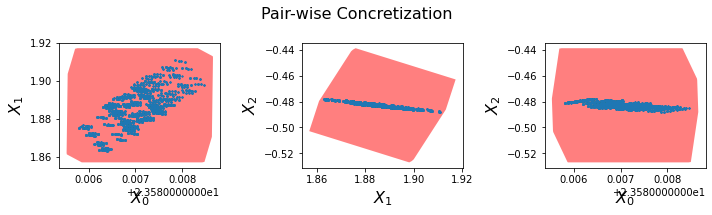

In [247]:
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plot_conretiztion([param[0], param[1]], 0.5)
plt.scatter([sp[0] for sp in sample_params_np], [sp[1] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel('$X_1$', fontsize=16)
# plt.axis('equal')

plt.subplot(132)
plot_conretiztion([param[1], param[2]])
plt.scatter([sp[1] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_1$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
# plt.axis('equal')

plt.subplot(133)
plot_conretiztion([param[0], param[2]])
plt.scatter([sp[0] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
# plt.axis('equal')
fig.suptitle('Pair-wise Concretization', fontsize=16)
plt.tight_layout()

#### Allow shared symbol with data

In [249]:
VT, sigma, V = np.linalg.svd(np.array((XR.T*XR).tolist()).astype(float))
V_mat = sympy.Matrix(V)
y_mat = sympy.Matrix(y)

wR = (XR.T*XR).inv()*XR.T*y_mat
wS_non_data = 0.0*V_mat.row(0).T
for i in range(len(symbolic_data[0])):
    wS_non_data = wS_non_data + sb(f'k{i}')*sb(f'ep{i}')*V_mat.row(i).T
    
eigenvalues = 1 - sigma/len(symbolic_data)*2*lamb
A = V_mat.inv()*np.diag(eigenvalues)*V_mat

wS_data = (np.identity(len(symbolic_data[0]))-A).inv()*((XS.T*XR + XR.T*XS)*wR 
                                                        - XS.T*y_mat)*(-lamb*2/len(symbolic_data))

wS = wS_non_data + wS_data
w = wS + wR
w_prime = (-lamb*2/len(symbolic_data))*((XS.T*XR + XR.T*XS + XS.T*XS)*wS + XS.T*XS*wR).expand()
w_prime_projected = V_mat*w_prime

In [250]:
eqs = []
for d in range(len(symbolic_data[0])):
    eq1 = (1-eigenvalues[d])*sb(f'k{d}')
    eq2 = 0
    coef_dict = dict()
    coef_dict['const'] = 0
    for i in range(len(symbolic_data[0])):
        coef_dict[sb(f'k{i}')] = 0
    for arg in w_prime_projected[d].args:
        contain_k = False
        for i in range(len(symbolic_data[0])):
            symb_k = sb(f'k{i}')
            if symb_k in arg.free_symbols:
                coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                contain_k = True
                break
        if not(contain_k):
            coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
    eq2 = coef_dict['const']
    for i in range(len(symbolic_data[0])):
        eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
    eqs.append(sympy.Eq(eq1, eq2))

In [251]:
result = sympy.solve(eqs, [sb(f'k{i}') for i in range(len(symbolic_data[0]))])

In [252]:
param = wR+wS.subs(result)

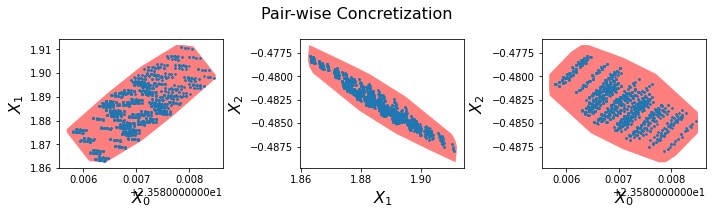

In [253]:
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plot_conretiztion([param[0], param[1]], 0.5, budget=10)
plt.scatter([sp[0] for sp in sample_params_np], [sp[1] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel('$X_1$', fontsize=16)
# plt.axis('equal')

plt.subplot(132)
plot_conretiztion([param[1], param[2]], budget=10)
plt.scatter([sp[1] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_1$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
# plt.axis('equal')

plt.subplot(133)
plot_conretiztion([param[0], param[2]], budget=10)
plt.scatter([sp[0] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
# plt.axis('equal')
fig.suptitle('Pair-wise Concretization', fontsize=16)
plt.tight_layout()

#### GD-based verification

In [254]:
def merge_small_components_pca(expr_ls, budget=10):
    if not(isinstance(expr_ls, sympy.Expr)):
        expr_ls = sympy.Matrix(expr_ls)
    if expr_ls.free_symbols:
        center = expr_ls.subs(dict([(symb, 0) for symb in expr_ls.free_symbols]))
    else:
        return expr_ls
    monomials_dict = get_generators(expr_ls)
    generators = np.array([monomials_dict[m] for m in monomials_dict])
    if len(generators) <= budget:
        return expr_ls
    monomials = [m for m in monomials_dict]
    
    VT, sigma, V = np.linalg.svd(np.matmul(np.concatenate([generators, -generators]).T, 
                                           np.concatenate([generators, -generators])))
    transformed_generators = np.matmul(V, generators.T).T
    transformed_generator_norms = np.linalg.norm(transformed_generators, axis=1, ord=2)
    
    # from largest to lowest norm
    sorted_indices = transformed_generator_norms.argsort()[::-1].astype(int)
    sorted_transformed_generators = transformed_generators[sorted_indices]
    sorted_monomials = [monomials[idx] for idx in sorted_indices]
    new_transformed_generators = np.concatenate([sorted_transformed_generators[:budget],
                                                 np.diag(np.sum(np.abs(sorted_transformed_generators[budget:]), axis=0))])
    new_generators = np.matmul(VT, new_transformed_generators.T).T
    new_monomials = sorted_monomials[:budget] + [create_symbol() for _ in range(len(generators[0]))]
    
    processed_expr_ls = center
    for monomial_id in range(len(new_monomials)):
        processed_expr_ls += sympy.Matrix(new_generators[monomial_id])*new_monomials[monomial_id]
    
    return processed_expr_ls


def merge_small_components_v_selected(expr_ls, symbols_in_data, symbolic_in_orig_weight, V, VT):
    if not(isinstance(expr_ls, sympy.Expr)):
        expr_ls = sympy.Matrix(expr_ls)
    if expr_ls.free_symbols:
        center = expr_ls.subs(dict([(symb, 0) for symb in expr_ls.free_symbols]))
    else:
        return expr_ls
    
    monomials_dict = get_generators(expr_ls)
    generators = np.array([monomials_dict[m] for m in monomials_dict])

    monomials = [m for m in monomials_dict]

    transformed_generators = np.matmul(V, generators.T).T
    transformed_generator_norms = np.linalg.norm(transformed_generators, axis=1, ord=2)
    
    selected_indices = []
    not_selected_indices = []
    for idx, monomial in enumerate(monomials_dict.keys()):
        if (monomial in symbols_in_data) or (monomial in symbolic_in_orig_weight):
            selected_indices += [idx]
        else:
            not_selected_indices += [idx]
    selected_indices = np.array(selected_indices).astype(int)
    not_selected_indices = np.array(not_selected_indices).astype(int)

    selected_transformed_generators = transformed_generators[selected_indices]
    selected_monomials = [monomials[idx] for idx in selected_indices]
    
    not_selected_transformed_generators = transformed_generators[not_selected_indices]
    
    new_transformed_generators = np.concatenate([selected_transformed_generators,
                                                 np.diag(np.sum(np.abs(not_selected_transformed_generators),
                                                                axis=0))])

    new_generators = np.matmul(VT, new_transformed_generators.T).T
    new_monomials = selected_monomials + [create_symbol() for _ in range(len(generators[0]))]
    
    processed_expr_ls = center
    for monomial_id in range(len(new_monomials)):
        processed_expr_ls += sympy.Matrix(new_generators[monomial_id])*new_monomials[monomial_id]
    
    return processed_expr_ls, new_transformed_generators

In [255]:
symbolic_data_mat = sympy.Matrix(symbolic_data)
new_param = copy.deepcopy(param)

for iteration in tqdm(range(2), desc='Symbolic'):
    preds_diff = symbolic_data_mat*new_param - y_mat
    grad = symbolic_data_mat.transpose()*preds_diff
    linearized_grad = linearization(grad)
    new_param_li = [new_param[j] - linearized_grad[j]*2*lamb/len(symbolic_data) 
                    for j in range(len(new_param))]
    new_param_or, new_gen = merge_small_components_v_selected(new_param_li, symbols_in_data, 
                                                              new_param.free_symbols, V, VT)
    new_param = sympy.Matrix(new_param_or)

Symbolic:   0%|          | 0/2 [00:00<?, ?it/s]

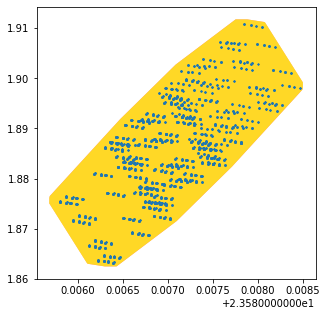

In [256]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
plot_conretiztion([param[0], param[1]], budget=10)

affset = merge_small_components_pca([new_param[0], new_param[1]], budget=10)
pts = np.array(list(map(list, get_vertices(affset))))
hull = ConvexHull(pts)
ax.fill(pts[hull.vertices, 0], pts[hull.vertices, 1], 'yellow', alpha=0.7)
plt.scatter([sp[0] for sp in sample_params_np], [sp[1] for sp in sample_params_np], s=0.75)

yellow and red parts overlap, verification passed!

## Non-random missing value injection

In [259]:
# pattern function that labels tuples in the given pattern as 1, and other tuples as 0
def pattern(data_X, data_y):
    binary_indicators = []
    for i in data_X.index:
        # choose subpopulation based on y (mpg) and origin
        satisfaction = ((data_y.loc[i][0] > 25) & (data_X.loc[i, 'origin'] == 1))
        if satisfaction:
            binary_indicators.append(1)
        else:
            binary_indicators.append(0)
    return np.array(binary_indicators)

In [260]:
# num of errors injected
mv_num = 5

# which col to inject missing val
uncertain_attr = 2

# num of tuples described by the pattern
mv_pattern_len = np.sum(pattern(X_train, y_train))

# inject into horsepower (3rd col in X)
mv_err = MissingValueError(uncertain_attr, pattern=pattern, ratio=mv_num/mv_pattern_len)
dirty_X_train, dirty_y_train, _, _ = mv_err.inject(X_train.copy(), y_train.copy(), X_train, y_train)

In [261]:
X = dirty_X_train.to_numpy()
y = dirty_y_train.to_numpy().ravel()
X_extended = np.append(np.ones((len(X), 1)), X, axis=1)
uncertain_attr += 1
ss = StandardScaler()
X_extended[:, 1:] = ss.fit_transform(X_extended[:, 1:])

imputers = [KNNImputer(n_neighbors=5), KNNImputer(n_neighbors=10), KNNImputer(n_neighbors=15),
            IterativeImputer()]

In [262]:
# missing horsepower in some rows
num_attrs = X_extended.shape[1]
X_nan = X_extended.copy()
imputed_cols = []
imputed_datasets = []
for imp in imputers:
    imputed_dataset = imp.fit_transform(X_nan)
    imputed_datasets.append(imputed_dataset)
    imputed_cols.append(imputed_dataset[:, uncertain_attr])

X_extended_max = X_extended.copy()
X_extended_max[:, uncertain_attr] = np.max(imputed_cols, axis=0)
X_extended_min = X_extended.copy()
X_extended_min[:, uncertain_attr] = np.min(imputed_cols, axis=0)

### Transform into symbolic expressions

In [263]:
# convert ranges into symbolic representation 
symbol_id = -1
symbolic_data = X_extended.tolist()
symbols_in_data = set()
symbol_to_position = dict()
XS = X_extended.tolist()
XR = X_extended.tolist()
for row in range(len(symbolic_data)):
    for col in range(len(symbolic_data[0])):
        xmin = X_extended_min[row][col]
        xmax = X_extended_max[row][col]
        if xmin != xmax:
            xmean = (xmax + xmin) / 2
            xradius = (xmax - xmin) / 2
            new_symbol = create_symbol()
            symbolic_data[row][col] = xmean + xradius*new_symbol
            XS[row][col] = xradius*new_symbol
            XR[row][col] = xmean
            symbols_in_data.add(new_symbol)
            symbol_to_position[new_symbol] = (row, col)
        else:
            XS[row][col] = 0
XS = sympy.Matrix(XS)
XR = sympy.Matrix(XR)

In [264]:
sample_params = []
for s in tqdm(range(10000), desc='Samples'):
    samp = sample_data(imputed_datasets, seed=s)
    sample_params.append(np.matmul(np.linalg.inv(np.matmul(samp.T, samp)), np.matmul(samp.T, y)))

sample_params_np = np.array(sample_params)

Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

### Calculate fixed point

#### Assume no shared symbol with data (1)

In [265]:
VT, sigma, V = np.linalg.svd(np.array((XR.T*XR).tolist()).astype(float))
V_mat = sympy.Matrix(V)
y_mat = sympy.Matrix(y)

wR = (XR.T*XR).inv()*XR.T*y_mat
wS = 0.0*V_mat.row(0).T
for i in range(len(symbolic_data[0])):
    wS = wS + sb(f'k{i}')*sb(f'ep{i}')*V_mat.row(i).T

w = wS + wR
w_prime = (-lamb*2/len(symbolic_data))*((XS.T*XR + XR.T*XS + XS.T*XS)*w - XS.T*y_mat).expand()
w_prime_projected = (V_mat*w_prime).expand()

In [266]:
lamb = 0.1
eigenvalues = 1 - sigma/len(symbolic_data)*2*lamb
eigenvalues

array([0.08940099, 0.7999658 , 0.80706864, 0.84686942, 0.90511791,
       0.97295083, 0.98633389, 0.99306815])

In [267]:
eqs = []
for d in range(len(symbolic_data[0])):
    eq1 = (1-eigenvalues[d])*sb(f'k{d}')
    eq2 = 0
    coef_dict = dict()
    coef_dict['const'] = 0
    for i in range(len(symbolic_data[0])):
        coef_dict[sb(f'k{i}')] = 0
    for arg in w_prime_projected[d].args:
        contain_k = False
        for i in range(len(symbolic_data[0])):
            symb_k = sb(f'k{i}')
            if symb_k in arg.free_symbols:
                coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                contain_k = True
        if not(contain_k):
            coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
    eq2 = coef_dict['const']
    for i in range(len(symbolic_data[0])):
        eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
    eqs.append(sympy.Eq(eq1, eq2))

In [268]:
result = sympy.solve(eqs, [sb(f'k{i}') for i in range(len(symbolic_data[0]))])

In [269]:
param = wR+wS.subs(result)

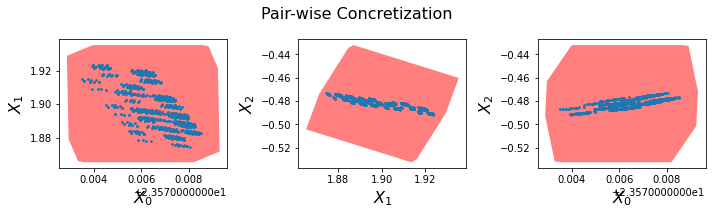

In [270]:
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plot_conretiztion([param[0], param[1]], 0.5)
plt.scatter([sp[0] for sp in sample_params_np], [sp[1] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel('$X_1$', fontsize=16)
# plt.axis('equal')

plt.subplot(132)
plot_conretiztion([param[1], param[2]])
plt.scatter([sp[1] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_1$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
# plt.axis('equal')

plt.subplot(133)
plot_conretiztion([param[0], param[2]])
plt.scatter([sp[0] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
# plt.axis('equal')
fig.suptitle('Pair-wise Concretization', fontsize=16)
plt.tight_layout()

#### Assume no shared symbol with data (2)

In [271]:
# VT, sigma, V = np.linalg.svd(np.array((XR.T*XR).tolist()).astype(float))
# V_mat = sympy.Matrix(V)
# y_mat = sympy.Matrix(y)

# wR = (XR.T*XR).inv()*XR.T*y_mat
# wS_non_data = 0.0*V_mat.row(0).T
# for i in range(len(symbolic_data[0])):
#     wS_non_data = wS_non_data + sb(f'k{i}')*sb(f'ep{i}')*V_mat.row(i).T
    
# eigenvalues = 1 - sigma/len(symbolic_data)*2*lamb
# A = V_mat.inv()*np.diag(eigenvalues)*V_mat

# wS_data = (np.identity(len(symbolic_data[0]))-A).inv()*((XS.T*XR + XR.T*XS)*wR - \
#                                                         XS.T*y_mat)

# wS = wS_non_data + wS_data
# w = wS + wR
# w_prime = (-lamb*2/len(symbolic_data))*((XS.T*XR + XR.T*XS + XS.T*XS)*wS + XS.T*XS*wR).expand()
# w_prime_projected = V_mat*w_prime

In [272]:
# eqs = []
# for d in range(len(symbolic_data[0])):
#     eq1 = sb(f'k{d}')
#     eq2 = 0
#     coef_dict = dict()
#     coef_dict['const'] = 0
#     for i in range(len(symbolic_data[0])):
#         coef_dict[sb(f'k{i}')] = 0
#     for arg in w_prime_projected[d].args:
#         contain_k = False
#         for i in range(len(symbolic_data[0])):
#             symb_k = sb(f'k{i}')
#             if symb_k in arg.free_symbols:
#                 coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
#                 contain_k = True
#         if not(contain_k):
#             coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
#     eq2 = coef_dict['const']
#     for i in range(len(symbolic_data[0])):
#         eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
#     eqs.append(sympy.Eq(eq1, eq2))

In [273]:
# result = sympy.solve(eqs, [sb(f'k{i}') for i in range(len(symbolic_data[0]))])

In [274]:
# param = wR+wS.subs(result)

In [275]:
# fig = plt.figure(figsize=(10, 3))
# plt.subplot(131)
# plot_conretiztion([param[0], param[1]])
# plt.scatter([sp[0] for sp in sample_params_np], [sp[1] for sp in sample_params_np], s=0.75)
# plt.xlabel('$X_0$', fontsize=16)
# plt.ylabel('$X_1$', fontsize=16)
# # plt.axis('equal')

# plt.subplot(132)
# plot_conretiztion([param[1], param[2]])
# plt.scatter([sp[1] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
# plt.xlabel('$X_1$', fontsize=16)
# plt.ylabel('$X_2$', fontsize=16)
# # plt.axis('equal')

# plt.subplot(133)
# plot_conretiztion([param[0], param[2]])
# plt.scatter([sp[0] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
# plt.xlabel('$X_0$', fontsize=16)
# plt.ylabel('$X_2$', fontsize=16)
# # plt.axis('equal')

# fig.suptitle('Pair-wise Concretization', fontsize=16)
# plt.tight_layout()

#### Allow shared symbol with data

In [276]:
VT, sigma, V = np.linalg.svd(np.array((XR.T*XR).tolist()).astype(float))
V_mat = sympy.Matrix(V)
y_mat = sympy.Matrix(y)

wR = (XR.T*XR).inv()*XR.T*y_mat
wS_non_data = 0.0*V_mat.row(0).T
for i in range(len(symbolic_data[0])):
    wS_non_data = wS_non_data + sb(f'k{i}')*sb(f'ep{i}')*V_mat.row(i).T
    
eigenvalues = 1 - sigma/len(symbolic_data)*2*lamb
A = V_mat.inv()*np.diag(eigenvalues)*V_mat

wS_data = (np.identity(len(symbolic_data[0]))-A).inv()*((XS.T*XR + XR.T*XS)*wR 
                                                        - XS.T*y_mat)*(-lamb*2/len(symbolic_data))

wS = wS_non_data + wS_data
w = wS + wR
w_prime = (-lamb*2/len(symbolic_data))*((XS.T*XR + XR.T*XS + XS.T*XS)*wS + XS.T*XS*wR).expand()
w_prime_projected = V_mat*w_prime

In [277]:
eqs = []
for d in range(len(symbolic_data[0])):
    eq1 = (1-eigenvalues[d])*sb(f'k{d}')
    eq2 = 0
    coef_dict = dict()
    coef_dict['const'] = 0
    for i in range(len(symbolic_data[0])):
        coef_dict[sb(f'k{i}')] = 0
    for arg in w_prime_projected[d].args:
        contain_k = False
        for i in range(len(symbolic_data[0])):
            symb_k = sb(f'k{i}')
            if symb_k in arg.free_symbols:
                coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                contain_k = True
                break
        if not(contain_k):
            coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
    eq2 = coef_dict['const']
    for i in range(len(symbolic_data[0])):
        eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
    eqs.append(sympy.Eq(eq1, eq2))

In [278]:
result = sympy.solve(eqs, [sb(f'k{i}') for i in range(len(symbolic_data[0]))])

In [279]:
param = wR+wS.subs(result)

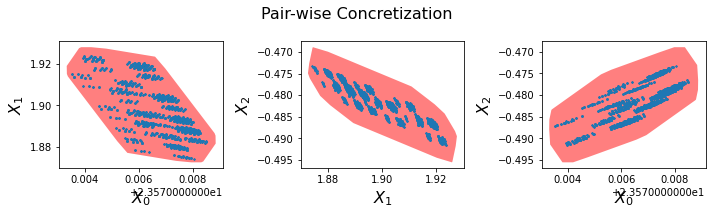

In [280]:
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plot_conretiztion([param[0], param[1]], 0.5, budget=10)
plt.scatter([sp[0] for sp in sample_params_np], [sp[1] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel('$X_1$', fontsize=16)
# plt.axis('equal')

plt.subplot(132)
plot_conretiztion([param[1], param[2]], budget=10)
plt.scatter([sp[1] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_1$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
# plt.axis('equal')

plt.subplot(133)
plot_conretiztion([param[0], param[2]], budget=10)
plt.scatter([sp[0] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
# plt.axis('equal')
fig.suptitle('Pair-wise Concretization', fontsize=16)
plt.tight_layout()

Feature correlation changes for non-random missing value (compared to random)!

In [281]:
# containment of sample params
def lp_zonotope_point_containment(point_param, zonotope_param):
    all_symbols = zonotope_param.free_symbols
    num_symbols = len(all_symbols)

    zero_subs = dict([(symb, 0) for symb in all_symbols])
    constant_part = np.array(zonotope_param.evalf(subs=zero_subs)).astype(float)

    bounds = [[-1, 1] for _ in range(num_symbols)]
    c = np.zeros((num_symbols, 1))

    Aeq = np.zeros((len(point_param), num_symbols))
    for dim in range(len(point_param)):
        param_dim = zonotope_param[dim]
        for symb_idx, symb in enumerate(all_symbols):
            Aeq[dim, symb_idx] = param_dim.coeff(symb)
    beq = point_param.reshape(-1, 1) - constant_part
    res = linprog(c=c, A_eq=Aeq, b_eq=beq, bounds=bounds)
    return res

for sp in tqdm(sample_params_np):
    assert lp_zonotope_point_containment(sp, param)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [114]:
# take a list of expressions as input, output the ordered list of monomials,
# the first ones refer to ones with overall larger coefficients.
def heuristic_based_choice_merge_small(expr_ls):
    monomials = get_generators(expr_ls)
    monomial_heuristic_vals = dict()
    for monomial, monomial_coefs in monomials.items():
        monomial_norm = np.linalg.norm(monomial_coefs)
        monomial_heuristic_vals[monomial] = monomial_norm
    monomials_ordered = sorted(list(monomial_heuristic_vals.items()), reverse=True, key=lambda x: x[1])
    return monomials_ordered


# prune components with small coefs
# the components with coef less than pruning_ratio * maximum_coef will be merged together
# budget is the maximum number of terms that can be kept in each dimension
def merge_small_components(expr_ls, pruning_ratio=1e3, budget=10, strategy='budget'):
    symb_ordered = heuristic_based_choice_merge_small(expr_ls)
    if strategy != 'budget':
        raise NotImplementedError
    symb_keep = set([p[0] for p in symb_ordered[:budget]])
    symb_merge = set([p[0] for p in symb_ordered[budget:]])
    processed_expr_ls = []
    for expr_id, expr in enumerate(expr_ls):
        if not(isinstance(expr, sympy.Expr)) or not(expr.free_symbols):
            processed_expr_ls.append(expr)
            continue
        expr = expr.expand()
        processed_expr = 0
        merged_coef = 0
        for arg in expr.args:
            if arg.free_symbols:
                pair = arg.args
                # if pair is empty, then coef = 1
                if pair:
                    coef, err_symbol = pair[0], pair[1]
                else:
                    coef, err_symbol = 1, arg
                if err_symbol in symb_keep:
                    processed_expr += arg
                else:
                    merged_coef += abs(coef)
            else:
                processed_expr += arg
    
        processed_expr += merged_coef * create_symbol()
        processed_expr_ls.append(processed_expr)
        
    return processed_expr_ls


def merge_small_components_pca(expr_ls, budget=10):
    if not(isinstance(expr_ls, sympy.Expr)):
        expr_ls = sympy.Matrix(expr_ls)
    if expr_ls.free_symbols:
        center = expr_ls.subs(dict([(symb, 0) for symb in expr_ls.free_symbols]))
    else:
        return expr_ls
    monomials_dict = get_generators(expr_ls)
    generators = np.array([monomials_dict[m] for m in monomials_dict])
    if len(generators) <= budget:
        return expr_ls
    monomials = [m for m in monomials_dict]
    pca = PCA(n_components=len(generators[0]))
    pca.fit(np.concatenate([generators, -generators]))
    transformed_generators = pca.transform(generators)
    transformed_generator_norms = np.linalg.norm(transformed_generators, axis=1, ord=2)
    # from largest to lowest norm
    sorted_indices = transformed_generator_norms.argsort()[::-1].astype(int)
    sorted_transformed_generators = transformed_generators[sorted_indices]
    sorted_monomials = [monomials[idx] for idx in sorted_indices]
    new_transformed_generators = np.concatenate([sorted_transformed_generators[:budget], 
                                                 np.diag(np.sum(np.abs(sorted_transformed_generators[budget:]), 
                                                                axis=0))])
    new_generators = pca.inverse_transform(new_transformed_generators)
    new_monomials = sorted_monomials[:budget] + [create_symbol() for _ in range(len(generators[0]))]
    
    processed_expr_ls = center
    for monomial_id in range(len(new_monomials)):
        processed_expr_ls += sympy.Matrix(new_generators[monomial_id])*new_monomials[monomial_id]
    
    return processed_expr_ls


def plot_conretiztion_labeled(affset, alpha=1, color='red', budget=-1, label=''):
    if budget > -1:
        affset = merge_small_components_pca(affset, budget=budget)
    pts = np.array(list(map(list, get_vertices(affset))))
    hull = ConvexHull(pts)
    plt.fill(pts[hull.vertices,0], pts[hull.vertices,1], color, label=label, alpha=alpha)